### 1. Обработка данных  

1. первое что делаем - находим нужные кодировку для чтения фалйа. сейчас это windows-1251, но вдруг изменится  
2. из итогов вытаскиваем № склада с помощью простого алгоритма, удаляем лищние нули  
3. ну и традиционно ВПРим по номеру склада ОП и ЛЦ.
4. Удаляем пустые строки

In [1]:
import pandas as pd
import charset_normalizer
from datetime import datetime, timedelta
import re
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


path = (r'C:\Users\Home\Desktop\Data\Выдача_из_ТЗ\doc-usl_апрель28.csv')


table_with_OS = pd.read_excel(r'C:\Users\Home\Desktop\Data\Склады\Склады.xlsx', sheet_name='склады')


with open(path, 'rb') as rawdata:
    result = charset_normalizer.detect(rawdata.read(10000))


df_all = pd.read_csv(path, encoding='windows-1251' , skiprows=14, sep=';')

def extract_sklad(row):
    text = str(row['Вид'])  
    words = text.split()  # Разделяем строку на слова по пробелам
    
    if len(words) >= 4 and len(words[3]) > 4:  # Проверяем, что в строке есть как минимум 4 элемента
        return words[3]  # Возвращаем четвертый элемент (индекс 3)
    else:
        return np.nan  # Возвращаем NaN, если в строке меньше 4 элементов

df_all['Склад'] = df_all.apply(extract_sklad, axis=1)

df_all.loc[:, 'Склад'] = df_all['Склад'].bfill()
df_all['Склад'] = df_all['Склад'].str.lstrip('0').replace('', '0')

df_all['Склад'] = df_all['Склад'].astype(str)

table_with_OS = table_with_OS.drop_duplicates(['Номер_склада'])

df_all['Склад'] = df_all['Склад'].astype(str).str.strip()
table_with_OS['Номер_склада'] = table_with_OS['Номер_склада'].astype(str).str.strip()

# # Создание словарей для 'Офис' и 'ЛЦ'
office_dict = table_with_OS.set_index('Номер_склада')['ОП'].to_dict()
lc_dict = table_with_OS.set_index('Номер_склада')['ЛЦ'].to_dict()

def get_LC(row):
    if row['Склад'] in lc_dict:
        return lc_dict[row['Склад']]
    else:
        return 'Не найдено'

def get_office(row):
    if row['Склад'] in office_dict:
        return office_dict[row['Склад']]
    else:
        return 'Не найдено'

df_all['ЛЦ по складу'] = df_all.apply(get_LC, axis=1)
df_all['Офис по складу'] = df_all.apply(get_office, axis=1)

df_all = df_all[(df_all['КодК/АгДок'].notna()) & (df_all['Дата'].notna())].copy()

df_all['ДатаИзм']

df_all = df_all[
    ~df_all['Офис по складу'].str.startswith('ОП при', na=False) &
    ~df_all['Офис по складу'].str.contains('СВК', na=False, regex=False)
].copy()

C:\Users\Home\AppData\Local\Temp\ipykernel_17760\2146190612.py:20: DtypeWarning: Columns (6,15,23,33,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(path, encoding='windows-1251' , skiprows=14, sep=';')


In [2]:
def define_point(office):
    if pd.isna(office):  # Проверка на NaN
        return "не определено"
    if office.startswith("ОП"):
        return "ОП"
    elif office.startswith("ВТЦ"):
        return "ВТЦ"
    elif office.startswith("МОП"):
        return "МОП"
    elif office.startswith("ФОП"):
        return "ФОП"
    else:
        return "не определено"

df_all['Категория офиса'] = df_all['Офис по складу'].apply(define_point)


print(df_all['Категория офиса'].value_counts())

Категория офиса
ОП               50282
ВТЦ               9566
ФОП               2020
не определено     1566
МОП                240
Name: count, dtype: int64


In [3]:
# алгоритм для нахождения и присваивания признака для интернет заказов
df_all[['Первый', 'Остальное']] = df_all['Номер док'].str.split('/', n=1, expand=True)

df_all['интернет-заказ'] = df_all['Первый'].apply(lambda x: 1 if x == "999" else 0)

### 2 Добавляем фичу по своевремеенности

1. Расчитыем разность дат между созданием заказа и его комплектаций. по 157 документам
2. Выходные дни убираем(значения после 18.00 имеют небольшую долю)
3. Если разность дат между созданием и комплктацией меньше или равна нулю, то заказ сделан своевременно

In [4]:
df_all['ДатаСозд.1'] = pd.to_datetime(df_all['ДатаСозд.1'], format='%d.%m.%Y')
df_all['ДатаИзм'] = pd.to_datetime(df_all['ДатаИзм'], format='%d.%m.%Y')
df_all['разность дат'] = (df_all['ДатаИзм'] - df_all['ДатаСозд.1']).dt.days
df_all['день недели(создания док-та)'] = df_all['ДатаСозд.1'].dt.dayofweek
df_all = df_all[~df_all['день недели(создания док-та)'].isin([5,6])].copy()
df_all = df_all.dropna(subset = ['Вид', 'Номер док'])
df_all['день'] = df_all['ДатаСозд.1'].dt.day
df_all['месяц'] = df_all['ДатаСозд.1'].dt.month
df_all['неделя'] = df_all['ДатаСозд.1'].dt.isocalendar().week

def in_time(row):
    if row['разность дат'] <= 0:
        return 1
    else:
        return 0

df_all['Своевременность']  = df_all.apply(in_time, axis=1)
df_all['день недели'] = df_all['день недели(создания док-та)'].apply(
    lambda x: np.where(x == 0, 'понедельник',
             np.where(x == 1, 'вторник',
             np.where(x == 2, 'среда',
             np.where(x == 3, 'четверг',
             np.where(x == 4, 'пятница',
             'неизвестно'))))))

df_all = df_all[df_all['ЛЦ по складу'] != 'Не найдено'].copy()

### 3 Визуализация и интерпритация 

Эксперементируем

In [5]:
df_pivot = df_all.pivot_table( values="Своевременность",
    columns="ЛЦ по складу",
    index=["день"])

df_pivot = df_pivot.apply(lambda x: x*100, axis=1)

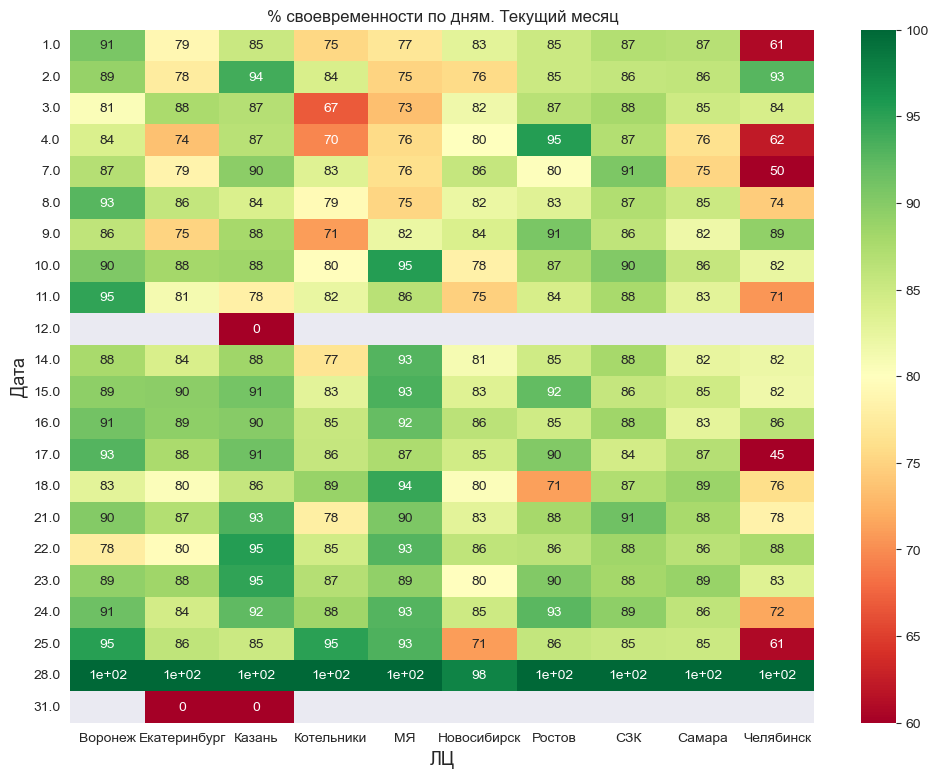

In [34]:
plt.figure(figsize=(12, 9))
sns.heatmap(data=df_pivot, annot=True, cmap="RdYlGn", vmin=60, vmax=100)
plt.title('% своевременности по дням. Текущий месяц')
plt.ylabel('Дата', fontsize=13)
plt.xlabel('ЛЦ', fontsize=13)
sns.set_style('dark')
plt.yticks(rotation=0)
plt.show()

### 4 Больше фичей

Внутри каждого ОП считаем своеврменность по месяцам, далее из этого строим ранг(распределяем места в зависимоти от % своевременности)
Такие данные могу пригодиться для интерактивных сводных в экселе, где мы определяем два лучших и два худших ОП внутри ЛЦ по месяцам. 

In [7]:
df_all['среднее значение в точке за месяц'] = df_all.groupby(['месяц', 'ЛЦ по складу', 'Офис по складу'])['Своевременность'].transform('mean')
df_all['среднее значение в точке за неделю'] = df_all.groupby(['месяц', 'ЛЦ по складу', 'Офис по складу', 'неделя'])['Своевременность'].transform('mean')

df_all['ранг'] = df_all.groupby(['месяц', 'ЛЦ по складу'])['среднее значение в точке за месяц'].rank(method='dense', ascending=False)
df_all['Место ЛЦ по скорости осблуж'] = df_all.groupby(['месяц'])['среднее значение в точке за месяц'].rank(method='dense', ascending=False)

def replace_last_two_ranks(group):
    # Получаем уникальные ранги, отсортированные по убыванию
    unique_ranks = sorted(group.unique(), reverse=True)
    unique_ranks = [x for x in unique_ranks if x != 0]
    # Берем два последних уникальных ранга (первые два в отсортированном списке)
    if len(unique_ranks) >= 1:
        group[group == unique_ranks[0]] = 100  # Последний ранг -> 100
    if len(unique_ranks) >= 2:
        group[group == unique_ranks[1]] = 99   # Предпоследний ранг -> 99
    return group

# Применяем функцию к столбцу 'ранг'
df_all['модифицированный_ранг'] = df_all.groupby(['месяц', 'ЛЦ по складу'])['ранг'].transform(lambda x: replace_last_two_ranks(x))

df_all['среднее значение в точке за месяц'] = round(df_all['среднее значение в точке за месяц'], 2)

columns_to_drop = ['ИНН', '079 R (МКБ)', 'С', 'У/Ф', 'Значение признака', 'ОП','Примечание признака', 'Артикул',  'ДП', 'ЦКГ', 'подЦКГ', 'Потенциал',
'Класс3', 'Класс33']
df_all = df_all.drop(columns_to_drop, axis=1)

18       1. Отлично. 95%-100%
19       1. Отлично. 95%-100%
20       1. Отлично. 95%-100%
21       1. Отлично. 95%-100%
22       1. Отлично. 95%-100%
                 ...         
63985      2. Хорошо. 85%-94%
63986      2. Хорошо. 85%-94%
63987      2. Хорошо. 85%-94%
63988      2. Хорошо. 85%-94%
63989      2. Хорошо. 85%-94%
Name: Критерий точки, Length: 60497, dtype: object

### 5. Создание когорт по точкам продаж, в зависимости от их своевременности выдачи заказов

In [ ]:
def measure_point(row):
    value = row['среднее значение в точке за месяц']
    if value >= 0.95:
        return '1. Отлично. 95%-100%'
    elif value >= 0.85:
        return '2. Хорошо. 85%-94%'
    elif value >= 0.80:
        return '3. Удовлетворительно. 80%-84%'
    else:
        return '4. Неудовлетворительно  0%-79%'

df_all['Критерий точки'] = df_all.apply(measure_point, axis=1)

def measure_point_week(row):
    value = row['среднее значение в точке за неделю']
    if value >= 0.95:
        return '1. Отлично. 95%-100%'
    elif value >= 0.85:
        return '2. Хорошо. 85%-94%'
    elif value >= 0.80:
        return '3. Удовлетворительно. 80%-84%'
    else:
        return '4. Неудовлетворительно  0%-79%'

df_all['Критерий точки за неделю'] = df_all.apply(measure_point_week, axis=1)

now = datetime.now()
today = now.date()
current_month = today.month 

In [16]:
df_all_pivot_points = df_all.groupby(['Критерий точки']).agg({
    'Офис по складу': 'nunique',
    'среднее значение в точке за месяц': ['count'],
    'Своевременность': ['mean', 'sum']
})
df_all_pivot_points.columns = [col[1] for col in df_all_pivot_points.columns]
df_all_pivot_points = df_all_pivot_points.reset_index()

df_all_pivot_points.columns = ['Критерий точки', 'Кол-во точек, шт', 'Всего док-ов, шт', 'Сред доля вовремя, %', 'Док-ов вовремя, шт']

df_all_pivot_points['Док-ов опоздало, шт'] = df_all_pivot_points['Всего док-ов, шт'] - df_all_pivot_points['Док-ов вовремя, шт']
df_all_pivot_points['Сред доля вовремя, %'] = df_all_pivot_points['Сред доля вовремя, %'].astype(float).round(2)

df_all_pivot_points
print('Аггрегировния информация о точках, исходя из их своевременности')

,Критерий точки,"Кол-во точек, шт","Всего док-ов, шт","Сред доля вовремя, %","Док-ов вовремя, шт","Док-ов опоздало, шт"
0,1. Отлично. 95%-100%,14,7021,0.96,6759,262
1,2. Хорошо. 85%-94%,85,32406,0.91,29426,2980
2,3. Удовлетворительно. 80%-84%,25,5818,0.82,4760,1058
3,4. Неудовлетворительно 0%-79%,60,15251,0.70,10614,4637


In [33]:
df_all_pivot_points_weeks = df_all.pivot_table( values='Офис по складу',
    index='Критерий точки за неделю',
    columns='неделя',
    aggfunc = 'nunique',
    fill_value=0,
    margins = True,
    margins_name= 'Итог' )

def calculate_percentage(df):
    result = round(df.div(df.loc['Итог'], axis=1), 2)
    return result
df_all_pivot_points_weeks = calculate_percentage(df_all_pivot_points_weeks)

print('Распределение кол-ва точек по категориям, по неделям:')
df_all_pivot_points_weeks.loc[:, 14:17].style.format('{:.2%}')

Распределение кол-ва точек по категориям, по неделям:


неделя,14,15,16,17
Критерий точки за неделю,,,,
1. Отлично. 95%-100%,16.00%,19.00%,21.00%,18.00%
2. Хорошо. 85%-94%,40.00%,40.00%,40.00%,48.00%
3. Удовлетворительно. 80%-84%,12.00%,11.00%,13.00%,11.00%
4. Неудовлетворительно 0%-79%,34.00%,30.00%,25.00%,23.00%
Итог,100.00%,100.00%,100.00%,100.00%


### 6 Выгрузка обработанных данных в excel

In [10]:
time_str = now.strftime("%H-%M-%S")  
archive_path = f"C:\\Users\\Home\\Desktop\\новая отчётность\\57_157 Товарные запасы\\данные своевременность 57_157 за {today}_{time_str}.xlsx"

with pd.ExcelWriter(archive_path, engine='openpyxl') as writer:
    df_all.to_excel(writer, sheet_name='данные', index=False)
    df_all_pivot_points_weeks.to_excel(writer, sheet_name='агрегации', index=True)